In [414]:
#Cargando librerias

import cobra.test
import cplex # usaremos el cluster UTEM
import pandas as pd
import numpy as np
import escher
from escher import Builder

In [415]:
#Cargamos el modelo de S.cerevisiae con datos transcriptómicos de la hoja Celton 
data=pd.read_excel("S2.xls",sheet_name="Transcriptomic data - Celton", index_col=0, header=0) 
model=cobra.io.read_sbml_model("iMM904.xml")

In [416]:
model

Name,iMM904
Memory address,0x07f7b6dd63590
Number of metabolites,1226
Number of reactions,1577
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


In [417]:
# Define una función para cargar los fpkm de acuerdo a las gene_reaction_rules

def getG(grl,fpkm):
    grl=grl.replace("(","")
    grl=grl.replace(")","")
    g = 0
    for subrule in grl.split("or"):
        g_subrule = []
        for gene in subrule.split("and"):
            gene = gene.replace(" ","")
            if gene in fpkm:
                g_subrule.append( float(fpkm[gene]) )
        if len(g_subrule)>=1: 
            g += min(g_subrule)
    return(g)

#print(g)

In [418]:
# Create a dictionary with the fpkm of each gene

fpkm={}

for gene in model.genes:
    if gene.id  in data.index:
        fpkm[gene] = data["RF"].loc[gene.id]
    #else:
    #    print(gene.id," not found")
    
#fpkm.values()

In [419]:
# Create a dictionary with the fpkm for each reaction 
g2 = {}
mean_g = np.mean(list(fpkm.values()) ) # useful when not a grl available

for reaction in model.reactions:
    if reaction.gene_reaction_rule == "":
        g2[reaction.id] = mean_g    
    else:
        g2[reaction.id] = getG(reaction.gene_reaction_rule,fpkm)

#g2
#mean_g RESULTA 5.6
#getG(reaction.gene_reaction_rule,fpkm) RESULTA 0

In [420]:
#1 Define objecive function
model=cobra.io.read_sbml_model("iMM904.xml")

for i, reaction in enumerate(model.reactions):
    if i == 0:
        dotProduct_expression  = model.reactions.get_by_id(reaction.id).forward_variable*g2[reaction.id]
        dotProduct_expression += model.reactions.get_by_id(reaction.id).reverse_variable*g2[reaction.id]
    else:
        dotProduct_expression += model.reactions.get_by_id(reaction.id).forward_variable*g2[reaction.id]
        dotProduct_expression += model.reactions.get_by_id(reaction.id).reverse_variable*g2[reaction.id]
        
#print(dotProduct_expression)

In [421]:
dotProduct_objective = model.problem.Objective(dotProduct_expression,direction="min")
model.objective = dotProduct_objective 


In [422]:
#Fijación de glucosa
model.reactions.get_by_id("EX_glc__D_e").bounds=(-90,-90)
model.reactions.get_by_id("EX_glc__D_e").bounds

(-90, -90)

In [423]:
solution_SPOT = model.optimize()

In [424]:
solution_SPOT

,fluxes,reduced_costs
CITtcp,0.000000,-1.121098e+01
13BGH,0.000000,0.000000e+00
13BGHe,0.000000,3.545800e+01
13GS,0.000000,1.772900e+01
16GS,0.000000,0.000000e+00
...,...,...
PYDXO,0.000000,1.776357e-15
PYK,22.333333,4.440892e-16
PYNP2r,0.000000,-6.518014e+00
PYR5CDm,0.000000,-1.776357e-15


In [425]:
builder=Builder(
    map_name="iMM904.Central carbon metabolism",
    model_name="iMM904",
)
builder.reaction_data=solution_SPOT.fluxes
builder

Builder(reaction_data={'CITtcp': 0.0, '13BGH': 0.0, '13BGHe': 0.0, '13GS': 0.0, '16GS': 0.0, '23CAPPD': 0.0, '…

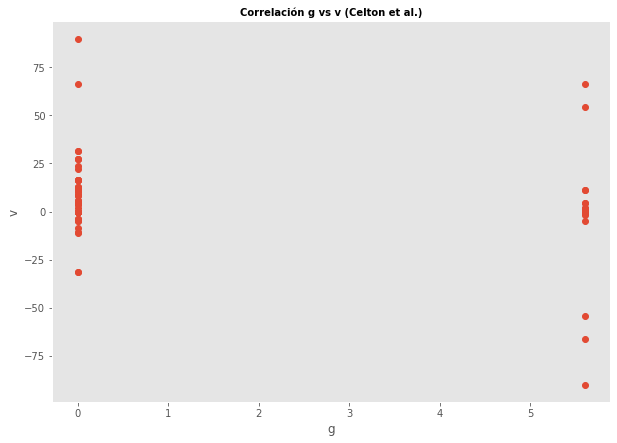

In [426]:
#NOS DA UN GRAFICO DE ESTE MODO DEBIDO A QUE LOS VALORES DE EXP GENETICA DESPUES DE LAS SUBREGLAS IMPUESTAS (g) SE CENTRAN EN 0 Y 5.6, NO HAY VARIABILIDAD, REVISAR.
import numpy as np
import scipy as sc
import matplotlib
import matplotlib.pyplot as plt

#Definiendo ejes

x=g.values()
y=solution_SPOT.fluxes
#Etiquetas de titulo y ejes
plt.plot(x, y.values[0:], 'o')

plt.title('Correlación g vs v (Celton et al.)',fontsize = 10,fontweight = "bold")
plt.xlabel('g')
plt.ylabel('v')


plt.grid()
plt.show()

In [427]:
flujos=['GHMT2r','THRA','ACS','PDHm','PC','PGI','PYK','PYRDC','ALCD2ir','ALDD2y','G3PT','EX_etoh_e','EX_ac_e','EX_glyc_e','EX_succ_e','EX_co2_e','TKT1','TALA','TKT2','PYRt2m']
flux_ex={'GHMT2r':0.14,'THRA':0.09,'ACS':0.3,'PDHm':1.37,'PC':4.21,'PGI':84.7,
         'PYK':169.2,'PYRDC':164.3,'ALCD2ir':162,'ALDD2y':2.42,'G3PT':17.8,
         'EX_etoh_e':162,'EX_ac_e':2.13,'EX_glyc_e':17.8,'EX_succ_e':0.3,'EX_co2_e':176.2,'TKT1':1.72,'TALA':3.79,'TKT2':5.65,'PYRt2m':0.41}

flux_pr=[]
flux_exl=[]
for i in flujos:    
    model.reactions.get_by_id(i)
    #print (model.reactions.get_by_id(i), model.reactions.get_by_id(i).name)
    print (i,'|',solution_SPOT[i],'|',flux_ex[i])
    flux_exl.append(flux_ex[i])
    flux_pr.append(solution_SPOT[i])


GHMT2r | 0.0 | 0.14
THRA | 0.0 | 0.09
ACS | 0.0 | 0.3
PDHm | 0.0 | 1.37
PC | 0.0 | 4.21
PGI | -3.8333333333333393 | 84.7
PYK | 22.33333333333332 | 169.2
PYRDC | 11.16666666666666 | 164.3
ALCD2ir | 0.0 | 162
ALDD2y | 0.0 | 2.42
G3PT | 16.499999999999996 | 17.8
EX_etoh_e | 0.0 | 162
EX_ac_e | 0.0 | 2.13
EX_glyc_e | 0.0 | 17.8
EX_succ_e | -0.0 | 0.3
EX_co2_e | 54.333333333333314 | 176.2
TKT1 | 10.666666666666668 | 1.72
TALA | 10.666666666666668 | 3.79
TKT2 | 6.0 | 5.65
PYRt2m | 0.0 | 0.41


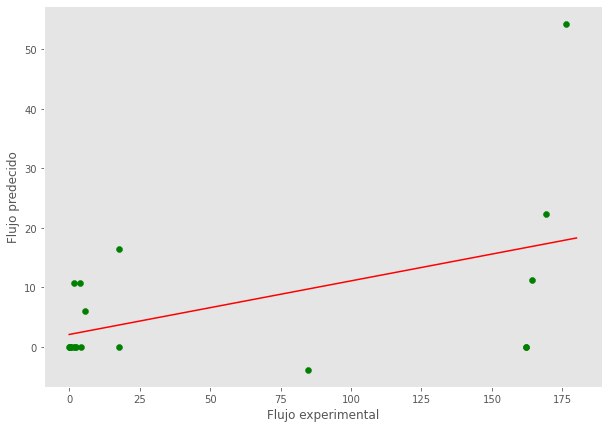

In [433]:
#plot entre predecido y experimental

x=flux_exl
y=flux_pr

plt.scatter(x,y,c="green")
plt.xlabel('Flujo experimental')
plt.ylabel('Flujo predecido')

#Agregar Linea de tendencia por medio de Minimos Cuadrados Ordinarios 
m=np.array([np.ones(20),x]).T #Para ejecutar de forma correcta la ec. Beta es necesario agregar una columna de 1 en el eje X
B=np.linalg.inv(m.T @m) @ m.T @y #ec. beta para realizar la linea de tendencia

plt.plot([0,180],[B[0]+B[1]*1,B[0]+B[1]*180],c="red") # Linea de tendencia

plt.grid()
plt.show()